In [36]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "purple"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  #plt.savefig("../results/plots/{}.png".format(title), dpi=600)
  plt.show()

In [38]:
fname = "../data/datasets.5000a.layer=6.masked=True.pickle"
fname2 = "../data/datasets.5000t.layer=6.masked=True.pickle"

with open(fname, "rb") as f:
    data = pickle.load(f)

    
with open(fname2, "rb") as f:
    data_nonlex = pickle.load(f)

In [32]:
projs_path = "../data/type2P.layer=6.iters=16.classifier=sgd.masked=True.pickle"
with open(projs_path, "rb") as f:
    type2proj = pickle.load(f)
    
comps = projs_path.split(".")
layer = comps[-5]
iters = comps[-4]
print(layer, iters)

layer=6 iters=16


In [33]:
data.keys()

dict_keys(['src', 'orc', 'orrc', 'prc', 'prrc'])

In [34]:
vecs, vecs_rowspace, labels = [],[], []
vecs_rowspace_nonlex = []
k = 300
type2vecs_rowspace = {}
type2vecs_rowspace_nonlex = {}

for type_pos in data.keys():
    
    print(type_pos)
    
    P_rowspace = np.eye(768) - type2proj[type_pos] #NOTE THE CHANGE
    #P_rowspace = np.eye(768) - type2proj["all"]
    
    train_x, train_y = data[type_pos]["train"]
    train_x_nonlex, train_y_nonlex = data_nonlex[type_pos]["train"]
    
    mask = train_y != 0
    mask_nonlex = train_y_nonlex != 0
    
    relevant_x = train_x[mask]
    relevant_x_nonlex = train_x_nonlex[mask_nonlex]
    
    label = [type_pos] * k
    vecs.append(relevant_x[:k])
    vecs_rowspace.append((relevant_x.dot(P_rowspace))[:k])
    vecs_rowspace_nonlex.append(relevant_x_nonlex.dot(P_rowspace)[:k])
    
    type2vecs_rowspace[type_pos] = relevant_x.dot(P_rowspace)
    type2vecs_rowspace_nonlex[type_pos] = relevant_x_nonlex.dot(P_rowspace)
    
    labels.extend(label)
vecs = np.concatenate(vecs, axis = 0)
vecs_rowspace = np.concatenate(vecs_rowspace, axis = 0)
vecs_rowspace_nonlex = np.concatenate(vecs_rowspace_nonlex, axis = 0)
labels = np.array(labels)
print(vecs.shape, len(labels))

src
orc
orrc
prc
prrc
(1500, 768) 1500


In [22]:
train_y[:100]

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0])

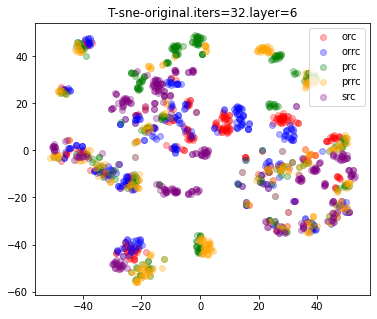

In [81]:
tsne(vecs, labels, "T-sne-original.{}.{}".format(iters, layer))

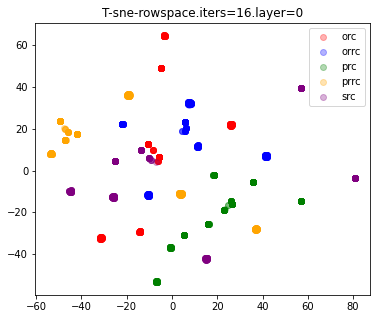

In [9]:
tsne(vecs_rowspace, labels, title = "T-sne-rowspace.{}.{}".format(iters, layer))

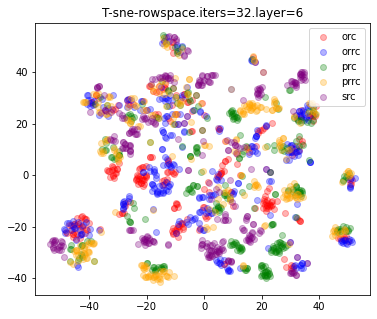

In [83]:
tsne(vecs.dot(np.eye(768) - type2proj["all"]), labels, title = "T-sne-rowspace.{}.{}".format(iters, layer))

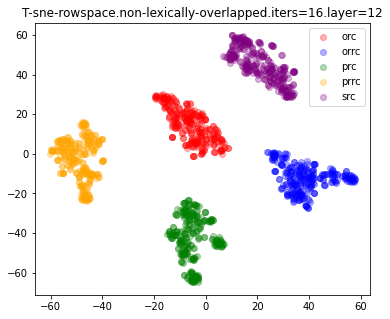

In [63]:
sims = np.zeros((6,6))tsne(vecs_rowspace_nonlex, labels, title = "T-sne-rowspace.non-lexically-overlapped.{}.{}".format(iters, layer))

In [23]:
sims = np.zeros((5,5))
type2ind = {d:i for i,d in enumerate(type2vecs_rowspace.keys())}
ind2type = {i:d for d,i in type2ind.items()}

In [24]:
type2vecs_rowspace

{'src': array([[-0.11842022, -0.29370283,  0.03215408, ..., -0.35386137,
         -0.07329512,  0.03422079],
        [-0.0919703 , -0.32722666,  0.10878417, ..., -0.33755407,
          0.00903774, -0.01577129],
        [-0.05507898, -0.22033033,  0.01878793, ..., -0.18824573,
          0.00908801,  0.05167292],
        ...,
        [-0.06792052, -0.24230361,  0.03445788, ..., -0.2871677 ,
         -0.03915588, -0.00357261],
        [-0.02177228, -0.15604751,  0.03966253, ..., -0.17377468,
         -0.00217446,  0.05753624],
        [-0.02740813, -0.15432635,  0.02294702, ..., -0.18242307,
         -0.01358395, -0.02310991]]),
 'orc': array([[ 0.00385727, -0.27198941,  0.06400521, ..., -0.19737002,
          0.19778609, -0.11461634],
        [ 0.0952131 , -0.28591814, -0.00920671, ..., -0.14616986,
          0.23523704, -0.14621947],
        [ 0.04428288, -0.25767964,  0.04221924, ..., -0.18425335,
          0.20706306, -0.08511909],
        ...,
        [ 0.07710678, -0.30538833,  0.00

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

for key, vecs in type2vecs_rowspace.items():
    for key2, vecs2 in type2vecs_rowspace_nonlex.items():
        #mean1, mean2 = np.mean(vecs, axis = 0), np.mean(vecs2, axis = 0)
        #mean1_normed, mean2_normed = mean1 / np.linalg.norm(mean1), mean2 / np.linalg.norm(mean2)
        
        sims2 = cosine_similarity(vecs, vecs2)
        print(sims2.shape)
        vecs_normed = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
        vecs2_normed = vecs2 / np.linalg.norm(vecs2, axis = 1, keepdims = True)
        
        sims[type2ind[key], type2ind[key2]] = np.mean(sims2) #mean1_normed.dot(mean2_normed.T)
        #sims[type2ind[key], type2ind[key2]] = np.mean(vecs.dot(vecs2.T))

(6206, 6402)
(6206, 6305)
(6206, 5116)
(6206, 8721)
(6206, 6305)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)
(5014, 6402)
(5014, 6305)
(5014, 5116)
(5014, 8721)
(5014, 6305)
(8602, 6402)
(8602, 6305)
(8602, 5116)
(8602, 8721)
(8602, 6305)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)


In [26]:
type2ind

{'src': 0, 'orc': 1, 'orrc': 2, 'prc': 3, 'prrc': 4}

In [27]:
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["src"].T).mean())
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["orc"].T).mean())

10.73899509822102
8.097509158253954


In [28]:
labels = [ind2type[i] for i in range(len(ind2type))]


In [29]:
def plot(labels, results, layer, classifier,iters):

    df_cm = pd.DataFrame(results, index = labels,
                  columns = labels)
    
    print(df_cm)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Cosine similarity in RC subspace between various RCs. {}. classifier: {}. {}".format(layer, classifier, iters))
    plt.show()
    plt.savefig("../results/plots/original-similarity.pairs:{}.classifier:{}.{}.png".format(layer, classifier, iters), dpi=300)    


           src       orc      orrc       prc      prrc
src   0.902036  0.620430  0.479327  0.332185  0.442034
orc   0.620315  0.886669  0.578937  0.359147  0.441946
orrc  0.474308  0.597883  0.929279  0.221234  0.305336
prc   0.324866  0.356355  0.221855  0.829187  0.519504
prrc  0.426254  0.435608  0.296681  0.508633  0.882350


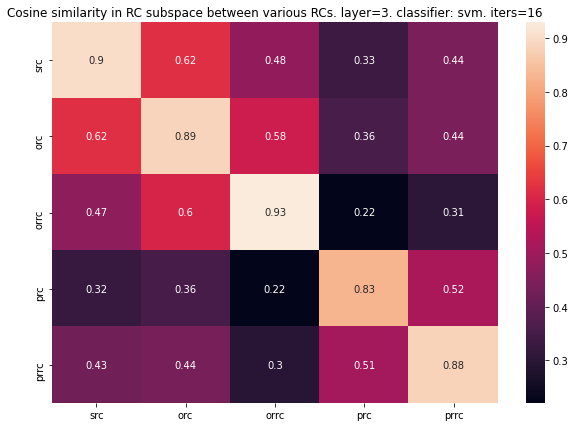

<Figure size 432x288 with 0 Axes>

In [30]:
plot(labels, sims, layer, "svm", iters)

           src       orc      orrc       prc      prrc
src   0.730259  0.318402  0.225999  0.189485  0.207873
orc   0.301241  0.787062  0.562664  0.329500  0.315654
orrc  0.220129  0.586864  0.775829  0.294025  0.291838
prc   0.198362  0.393432  0.348137  0.717978  0.362209
prrc  0.199553  0.354041  0.325490  0.352549  0.669115


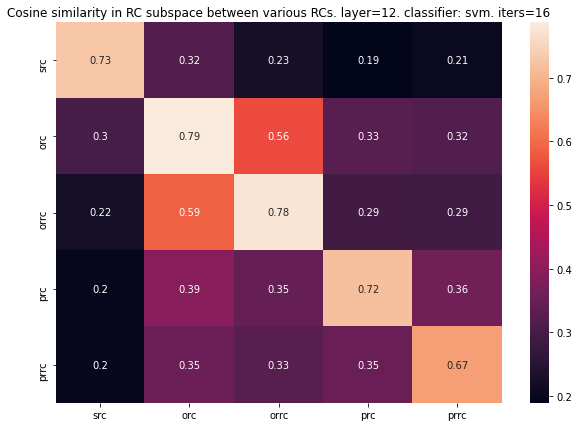

<Figure size 432x288 with 0 Axes>

In [72]:
plot(labels, sims, layer, "svm", iters)